In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sin, cos, sqrt, atan2, exp
import geopy.distance
import random
import time
import seaborn as sns
from matplotlib.animation import FuncAnimation

In [2]:
df = pd.read_csv("city.csv")

In [3]:
df = df.sort_values(by=['population'],ascending=False)[:30]

In [4]:
df

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
509,г Москва,101000.0,Россия,Центральный,г,Москва,NaN,NaN,NaN,NaN,...,1,0,45000000000,45000000,7700,UTC+3,55.754047,37.620405,11514330,1147
786,г Санкт-Петербург,190000.0,Россия,Северо-Западный,г,Санкт-Петербург,NaN,NaN,NaN,NaN,...,1,0,40000000000,40000000,7800,UTC+3,59.939131,30.315900,4848742,1703
647,г Новосибирск,630000.0,Россия,Сибирский,обл,Новосибирская,NaN,NaN,г,Новосибирск,...,4,2,50401000000,50701000001,5400,UTC+7,55.028191,82.921149,1498921,1893
832,г Екатеринбург,620000.0,Россия,Уральский,обл,Свердловская,NaN,NaN,г,Екатеринбург,...,4,2,65401000000,65701000001,6600,UTC+5,56.838522,60.605491,1377738,1723
619,г Нижний Новгород,603000.0,Россия,Приволжский,обл,Нижегородская,NaN,NaN,г,Нижний Новгород,...,4,2,22401000000,22701000001,5200,UTC+3,56.324063,44.005391,1250615,1221
927,г Казань,420000.0,Россия,Приволжский,Респ,Татарстан,NaN,NaN,г,Казань,...,4,2,92401000000,92701000001,1600,UTC+3,55.794358,49.111497,1216965,1005
782,г Самара,443000.0,Россия,Приволжский,обл,Самарская,NaN,NaN,г,Самара,...,4,2,36401000000,36701000,6300,UTC+4,53.195031,50.106952,1164900,1586
656,г Омск,644000.0,Россия,Сибирский,обл,Омская,NaN,NaN,г,Омск,...,4,2,52401000000,52701000001,5500,UTC+6,54.984857,73.367452,1154000,1716
1064,г Челябинск,454000.0,Россия,Уральский,обл,Челябинская,NaN,NaN,г,Челябинск,...,4,2,75401000000,75701000001,7400,UTC+5,55.160262,61.400808,1130273,1736
757,г Ростов-на-Дону,344000.0,Россия,Южный,обл,Ростовская,NaN,NaN,г,Ростов-на-Дону,...,4,2,60401000000,60701000001,6100,UTC+3,47.222457,39.718803,1091544,1749


In [6]:
class City:
  def __init__(self, address, geo_lat, geo_lon):
    self.address = address
    self.geo_lat = geo_lat
    self.geo_lon = geo_lon
  
  def __repr__(self):
    return f"{self.address}: ({self.geo_lat, self.geo_lon})"

cities = []
for _, row in df.iterrows():
  cities.append(City(row['address'], row['geo_lat'], row['geo_lon']))
cities = np.array(cities)
cities[0]

г Москва: ((55.7540471, 37.620405))

In [7]:
def get_distance_between_two_cities(coords_1, coords_2):
    return geopy.distance.geodesic(coords_1, coords_2).km


In [8]:
def get_proposal_state(current_state):
  indices = np.random.choice(len(current_state), 2, replace=False)

  proposed_state = np.copy(current_state)
  proposed_state[[indices[0], indices[1]]] = proposed_state[[indices[1], indices[0]]]
  return proposed_state

In [9]:
def get_path_length(state):
  length = get_distance_between_two_cities((state[-1].geo_lat,state[-1].geo_lon), (state[0].geo_lat,state[0].geo_lon))
  for i in range(1, len(state)):
    length += get_distance_between_two_cities((state[i-1].geo_lat,state[i-1].geo_lon), (state[i].geo_lat,state[i].geo_lon))
  return length

In [10]:
def get_next_state(current_state, T):
    proposed_state = get_proposal_state(current_state)
    energy_current = get_path_length(current_state)
    energy_proposed = get_path_length(proposed_state)
    if energy_proposed < energy_current:
        return proposed_state
    elif np.exp((energy_current-energy_proposed)/T) >= np.random.rand(1)[0]:
        return proposed_state
    else:
        return current_state

In [11]:
def do_annealing(initial_state, T, rate):
    current_state = initial_state
    logs = [current_state]
    start_time = time.time()
    while T > 1:
        current_state = get_next_state(current_state, T)
        T = T*rate
        logs.append(current_state)
    
    end_time = time.time()
    final_result = logs[-1]
    final_length = get_path_length(final_result)
    execution_time = end_time -start_time
    return logs, execution_time


In [ ]:
do_annealing(cities, 1000, 0.4)

In [13]:
def plot_execution_times_lengths(cities):
    T = 1000
    rates = [0.1,0.5,0.9, 0.99]
    times = []
    lengths = []
    for rate in rates:
        logs, time = do_annealing(cities, T, rate)
        lengths.append(get_path_length(logs[-1]))
        times.append(time)

    y = [i+1 for i in range(len(rates))]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    f.set_figheight(7)
    f.set_figwidth(13)
    # print(len(rates), len(time))
    ax1.plot(rates, times, '--bo',color = 'c')
    ax1.set_xlabel("SA rates")
    ax1.set_ylabel("Time in seconds")
    ax1.set_title('Execution Time')
    ax2.plot(rates, lengths, '--bo',color = 'c')
    ax2.set_title('Path Length')
    ax2.set_ylabel("Legth of Path in Km")
    ax2.set_xlabel("SA rates")
    plt.xticks(rates)
    
    

<ipython-input-13-a0a999335740>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(rates, times, '--bo',color = 'c')
<ipython-input-13-a0a999335740>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(rates, lengths, '--bo',color = 'c')


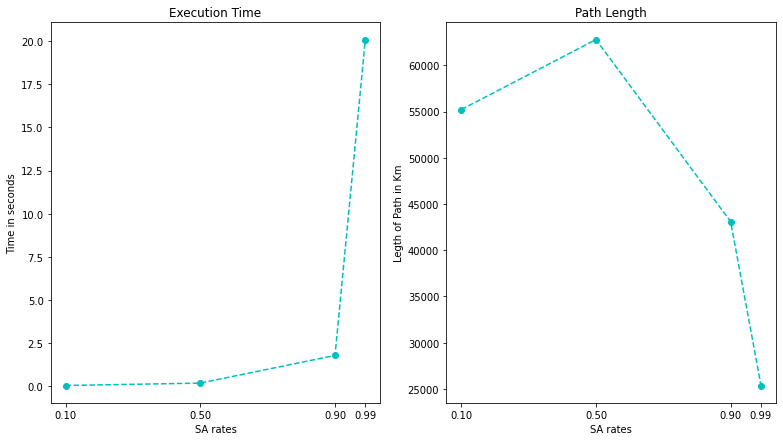

In [14]:
plot_execution_times_lengths(cities)

Text(0, 0.5, 'Path Length in Km')

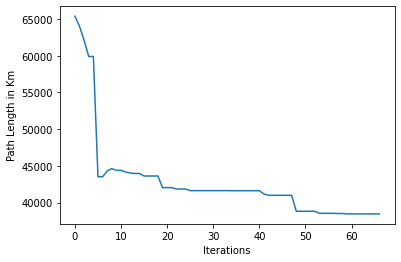

In [22]:
history, time = do_annealing(cities, 1000, 0.9)
X = []
Y = []
for index, frame in enumerate(history):
    X.append(get_path_length(frame))
    Y.append(index)
plt.plot(Y,X)
plt.xlabel("Iterations")
plt.ylabel("Path Length in Km")


In [25]:
import time

MovieWriter imagemagick unavailable; using Pillow instead.


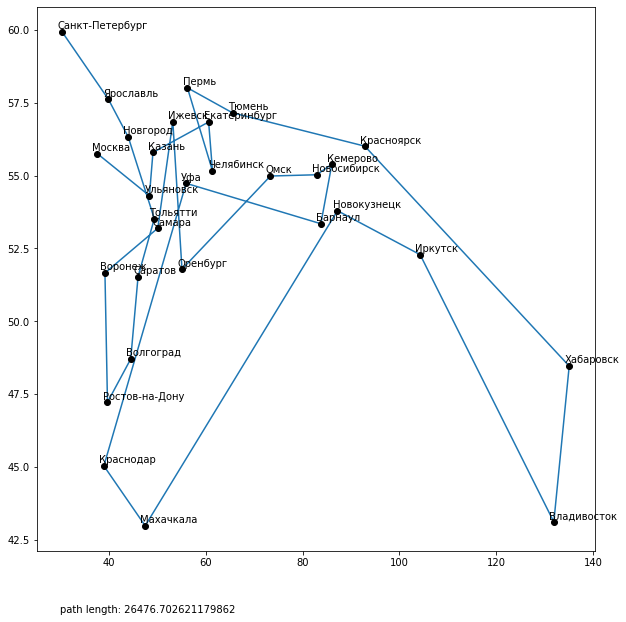

In [26]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()

path, = ax.plot([], [])
text = ax.text(30, 40, '')

history, times = do_annealing(cities, 1300, 0.99)

def init():
  path.set_data([], [])
  text.set_text('')
  return path, text

def animate(i):
  current_state = history[i]
  geo_lats = []
  geo_lons = []
  for city in current_state:
    geo_lats.append(city.geo_lon)
    geo_lons.append(city.geo_lat)
  path.set_data(geo_lats, geo_lons)
  text.set_text(f"path length: {get_path_length(current_state)}")
  return path, text

for city in cities:
    ax.plot(city.geo_lon, city.geo_lat, marker='o', color='black')
    ax.text(city.geo_lon - 1, city.geo_lat + 0.1, city.address.split()[-1])
 

result = FuncAnimation(fig, animate, init_func=init, frames=len(history) - 1, interval=20, repeat=False)
result.save('result.gif', writer='imagemagick')

plt.show()

In [14]:
import geopandas as gpd
from shapely.affinity import translate
from shapely.geometry import LineString, Point
from shapely.ops import split
from geopy.distance import distance as geodesic_distance

In [15]:
def get_cities_geodataframe(cities):
    geometry = [translate(Point(xy), xoff=-90) for xy in zip(cities['geo_lon'], cities['geo_lat'])]
    return gpd.GeoDataFrame(cities, geometry=geometry)

In [16]:
def shift_geom(shift, gdataframe):
    shift -= 180
    moved_map = []
    splitted_map = []
    border = LineString([(shift,90),(shift,-90)])

    for row in gdataframe["geometry"]:
        splitted_map.append(split(row, border))
    for element in splitted_map:
        items = list(element)
        for item in items:
            minx, miny, maxx, maxy = item.bounds
            if minx >= shift:
                moved_map.append(translate(item, xoff=-180-shift))
            else:
                moved_map.append(translate(item, xoff=180-shift))

    return gpd.GeoDataFrame({"geometry": moved_map})

In [ ]:
def russia():
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    russia = world[world['name'] == 'Russia']
    russia_shifted = shift_geom(90, russia)
    return russia_shifted